In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

print('얍💢')

얍💢


In [3]:
data_dir = os.getenv("HOME")+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [4]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 데이터 전처리 시작 

date 컬럼의 하위 항목이 거슬리기 때문에 슬라이싱으로 잘라준다  
`astype` 사용해서 int 정수형 데이터로 처리

In [5]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [6]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [7]:
del train['id']
print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


### 전처리 완료

#### 테스트 데이터에 대해서도 같은 작업 진행


In [8]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [9]:
y # 타겟 데이터 y 확인

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

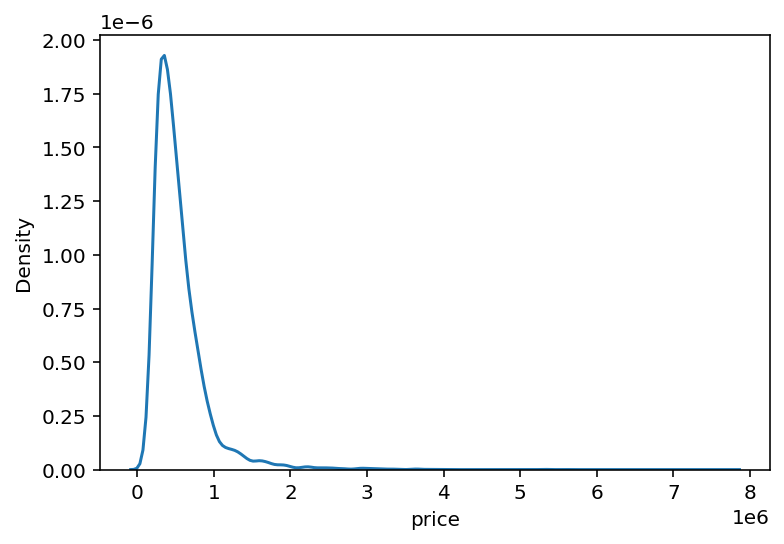

In [10]:
sns.kdeplot(y)
plt.show()

In [11]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

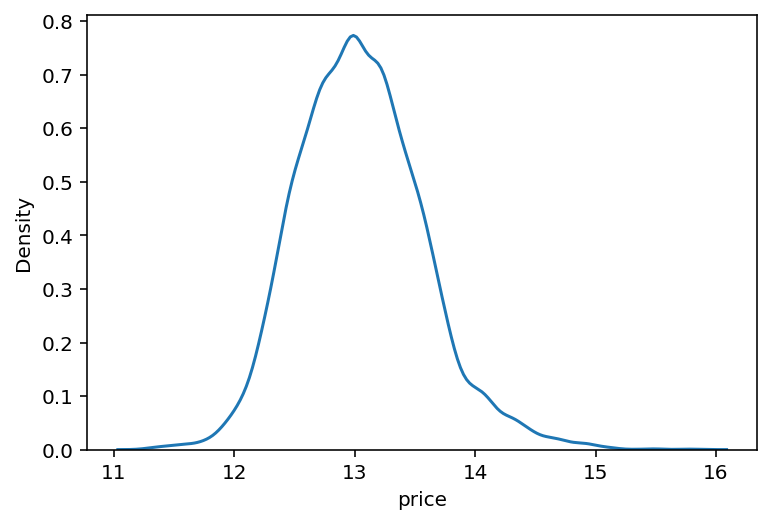

In [12]:
sns.kdeplot(y)
plt.show()

비교적 완만한 정규분포의 형태로 변환

In [13]:
train.info() # 전체 데이터 자료형 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

## 모델 튜닝



In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [15]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [16]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor



In [17]:
rs = 2020

gboost = GradientBoostingRegressor(random_state=rs)
xgboost = XGBRegressor(random_state=rs)
lightgbm = LGBMRegressor(random_state=rs)
rdforest = RandomForestRegressor(random_state=rs)

models = [gboost, xgboost, lightgbm, rdforest]

In [18]:
lightgbm.__class__.__name__

'LGBMRegressor'

df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=rs, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

In [19]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=rs, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df
            
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359
XGBRegressor,110318.669566


In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 30],
    'boosting_type': 'gbdt',
    'num_iterations' : [1000, 1100],
    
}

model = LGBMRegressor(random_state=rs)

grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

grid_model.cv_results_

params = grid_model.cv_results_['params']
params

score = grid_model.cv_results_['mean_test_score']
score

results = pd.DataFrame(params)
results['score'] = score

results

results['RMSE'] = np.sqrt(-1 * results['score'])
results

results = results.rename(columns={'RMSE': 'RMSLE'})
results

results = results.sort_values('RMSLE')
results

In [21]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=verbose, n_jobs=n_jobs)
    
    grid_model.fit(train, y)

    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    results = pd.DataFrame(params)
    results['score'] = score
    
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [29]:
import numpy as np

param_grid = {
#     'n_estimators': range(926, 965, 4),
    'n_estimators': [926],
    'max_depth': [9, 14, 16],
#     'boosting_type': 'gbdt',
    'learning_rate' : np.arange(0.026, 0.057, 0.004),
}

model = LGBMRegressor(random_state=rs)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
13,0.042,14,926,-0.025753,0.160477
8,0.034,16,926,-0.025765,0.160515
9,0.038,9,926,-0.025789,0.160590
11,0.038,16,926,-0.025810,0.160653
6,0.034,9,926,-0.025811,0.160658
7,0.034,14,926,-0.025812,0.160663
0,0.026,9,926,-0.025816,0.160673
1,0.026,14,926,-0.025819,0.160684
3,0.030,9,926,-0.025823,0.160694
14,0.042,16,926,-0.025829,0.160715


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

In [ ]:
def my_RandomSearch(model, train, y, param_distributions, verbose=2, n_jobs=-1):
    random_model = RandomizedSearchCV(model, param_distributions=param_distributions, scoring='neg_mean_squared_error',n_iter=10, cv=5, n_jobs=-1)
    random_model.fit(train, y)
    
    params = random_model.cv_results_['params']
    score = random_model.cv_results_['mean_test_score']
    
    results = pd.DataFrame(params)
    results['score'] = score
    
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    
    return results

In [ ]:
param_distributions = {
    'max_depth' : randint(9, 15),
    'learning_rate' : uniform(0.023, 0.0463),
    'n_estimators' : randint(920, 970),
#     'num_leaves' : randint(31, 60),
#     'subsample' : uniform(0.8, 1),
#     'min_child_sample' : randint(20, 40),
}

model = LGBMRegressor(random_state=rs)
my_RandomSearch(model, train, y, param_distributions, verbose=2, n_jobs=-1)

model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=rs)
model.fit(train, y)
prediction = model.predict(test)
prediction

prediction = np.expm1(prediction)
prediction

data_dir = os.getenv("HOME")+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

submission['price'] = prediction
submission.head()

submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

In [25]:
def save_submission(model, train, y, test, model_name, rmsle):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv("HOME")+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print("Success")

In [33]:
model = LGBMRegressor(learning_rate=0.042, max_depth=14, n_estimators=926, num_iteration=932)

save_submission(model, train, y, test, 'lgbm', rmsle='0.1604')

[LightGBM] [Warning] num_iterations is set=932, num_iteration=932 will be ignored. Current value: num_iterations=932
Success
[CV] END .learning_rate=0.026, max_depth=9, n_estimators=926; total time=   3.3s
[CV] END ..learning_rate=0.03, max_depth=9, n_estimators=926; total time=   2.4s
[CV] END ..learning_rate=0.03, max_depth=9, n_estimators=926; total time=   2.4s
[CV] END .learning_rate=0.034, max_depth=9, n_estimators=926; total time=   2.8s
[CV] END .learning_rate=0.034, max_depth=9, n_estimators=926; total time=   2.0s
[CV] END .learning_rate=0.038, max_depth=9, n_estimators=926; total time=   2.0s
[CV] END .learning_rate=0.038, max_depth=9, n_estimators=926; total time=   2.0s
[CV] END learning_rate=0.041999999999999996, max_depth=9, n_estimators=926; total time=   1.9s
[CV] END learning_rate=0.041999999999999996, max_depth=9, n_estimators=926; total time=   1.9s
[CV] END .learning_rate=0.046, max_depth=9, n_estimators=926; total time=   2.0s
[CV] END .learning_rate=0.046, max_de

## 회고
이번 Exploration 05번은 문제의 본질에 대해서 제대로 이해하지 못했다   
처음에 이 과정 자체가 무엇을 위한 것인지 제대로 판단하지 못했었어 어떻게 공부해야할지 전혀 갈피를 못 잡았다     
그저 순차적으로 진행하면서 이번 노드의 목적이 무었인지 생각안하고 하다보니 그나마 하이퍼파라미터를 수정하는 것을 조금이나마 알았고        
전체적인 흐름을 전혀 이해하지 못해서 제출하는 과제조차 그나마 이해한 GridSearchCV를 이용한 가장 적합한 하이퍼파라미터를 찾아내는 과정만 겨우 했을 뿐이다    

중간에 하이퍼파라미터에 대해서 좀더 적합한 범위를 잡기 위해서 랜덤 서치를 사용해 적당한 값을 찾았고      
조금 더 정확하게 확인해보고 싶어서 다시 GridSearch에 가장 괜찮았던 점수들을 범위로 지정해서 다시 넣어주는 작업을 반복했다.    
그러다 보니 6750개 fitting을 진행하기도 해서 점심시간을 활용해 돌렸는데 한시간이 넘게 걸렸다

사용한 매개변수는 max_depth, learning_rate, n_estimators 세 개를 사용했다
계속해서 110000보다 큰 값이 나와서 num_leaves, min_child_samples를 추가로 사용해 보았지만 오히려 더 수치가 나오게 되어서 제외하고 최적의 범위를 찾아가다보니 적절한 값이 나오게 되었다


결론 이해가 많이 부족한 노드였다.
조금더 공부를 한 후에 다시한번 찾아 와야할 노드


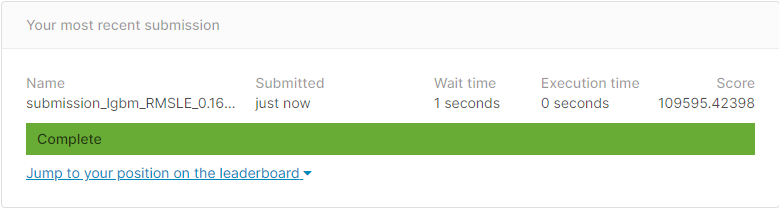

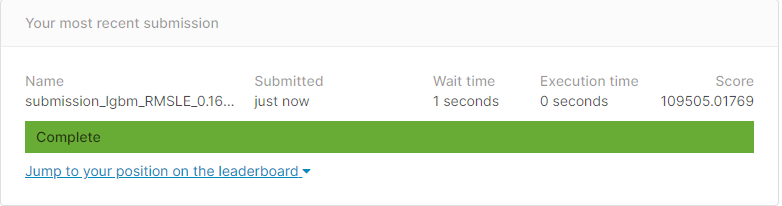